In [96]:
import pandas as pd

news = pd.read_csv('news_articles.csv')
news = news[news['language'] == 'english']

news.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \r\nfox news sunday reported this m...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


Remove unimportant columns and add a length column. Typically articles below a certain length threshold are very
unlikely to actually be articles. Let's remove observations with text below a certain length.

In [97]:
# remove all columns except publication data, title, text, type, and label
news = news[['published', 'title', 'text', 'type', 'label']].dropna().reset_index(drop=True)

# add a length feature
news['length']  = news['text'].str.len()

# remove observation with text below a certain length
news = news.loc[news['length'] >= 500]

og_news = news.copy()

news.head()

,published,title,text,type,label,length
1,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,bias,Real,1724
2,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \r\nfox news sunday reported this m...,bias,Real,1326
4,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,bias,Real,2052
5,2016-11-02T16:31:28.550+02:00,hillary goes absolutely berserk on protester a...,print hillary goes absolutely berserk she expl...,bias,Real,1165
6,2016-11-04T19:40:00.000+02:00,breaking nypd ready to make arrests in weiner ...,breaking nypd ready to make arrests in weiner ...,bias,Real,5653


Create histogram to examine number of articles with 'Real' vs 'Fake' labels.

In [98]:
import plotly.express as px

fig = px.histogram(news, x="label")
fig.show()

Examine distribution or article types.

In [99]:
fig = px.histogram(news, x="type")
fig.show()

Evaluate distribution of article lengths.

In [100]:
fig = px.histogram(news, x="length")
fig.show()

In [101]:
fig = px.histogram(news, x="length", color="label")
fig.show()

In [102]:
# Load the regular expression library
import re
# Remove punctuation
news['title_processed'] = \
news['title'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert text to lowercase
news['title_processed'] = \
news['title_processed'].map(lambda x: x.lower())
# Print out the first rows of news
news['title_processed'].head()

1    re why did attorney general loretta lynch plea...
2    breaking weiner cooperating with fbi on hillar...
4    fantastic trumps  point plan to reform healthc...
5    hillary goes absolutely berserk on protester a...
6    breaking nypd ready to make arrests in weiner ...
Name: title_processed, dtype: object

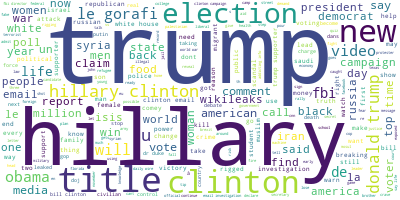

In [103]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(news['title_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [104]:
#Prepare for LDA analysis
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = news.title_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['attorney', 'general', 'loretta', 'lynch', 'plead', 'fifth']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [106]:
#LDA
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

In [107]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"clinton" + 0.005*"trump" + 0.005*"hillary" + 0.004*"life" + '
  '0.004*"us" + 0.004*"election" + 0.004*"gorafi" + 0.003*"new" + 0.003*"le" + '
  '0.003*"fbi"'),
 (1,
  '0.012*"hillary" + 0.007*"trump" + 0.006*"clinton" + 0.005*"fbi" + '
  '0.004*"email" + 0.004*"le" + 0.004*"campaign" + 0.004*"gorafi" + '
  '0.003*"investigation" + 0.003*"comment"'),
 (2,
  '0.021*"title" + 0.020*"trump" + 0.015*"clinton" + 0.010*"hillary" + '
  '0.006*"election" + 0.006*"donald" + 0.005*"life" + 0.004*"le" + '
  '0.004*"news" + 0.004*"say"'),
 (3,
  '0.022*"trump" + 0.015*"hillary" + 0.010*"clinton" + 0.006*"us" + '
  '0.006*"donald" + 0.006*"video" + 0.004*"new" + 0.003*"clintons" + '
  '0.003*"media" + 0.003*"obama"')]


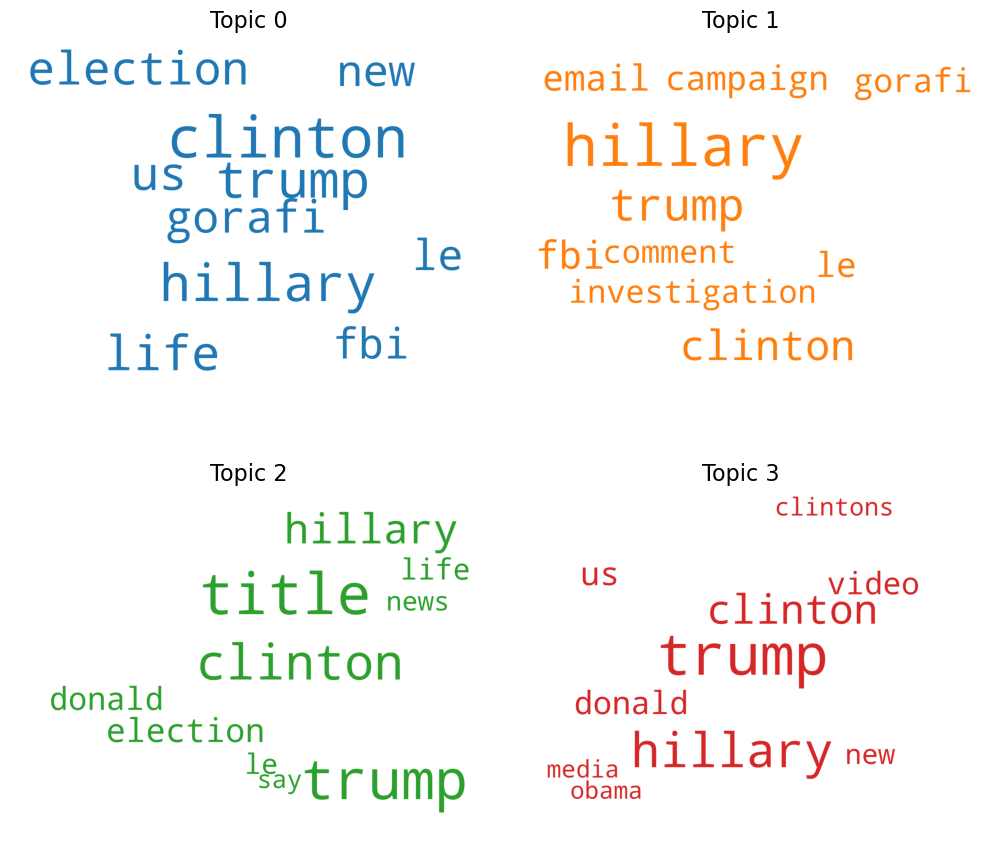

In [108]:
# Visualize the topics
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [109]:
# perform stratified sampling to get a balanced, sample dataset
sample_news = og_news.groupby('label', group_keys=False).apply(lambda x: x.sample(100, random_state=1))

# shuffle the observations so real and fake labels are not grouped together
from sklearn.utils import shuffle
sample_news = shuffle(sample_news, random_state=1)

At the moment, the text is unbearable to read. Let's add punctuation using Hugging Face's bert-restore-punctuation.

In [115]:
from deepmultilingualpunctuation import PunctuationModel
model = PunctuationModel()

for i in range(len(sample_news)):
    sample_news.at[i, "text"] = model.restore_punctuation(sample_news["text"].iloc[i])

AssertionError: chunk size too large, text got clipped

In [ ]:
def capitalize_sentences(s):
    # Split the string into sentences using period (.), exclamation mark (!), or question mark (?) as the delimiter
    sentences = re.split('(?<=[.!?]) +', s)
    
    # Capitalize the first letter of each sentence
    capitalized_sentences = [sentence.capitalize() for sentence in sentences]
    
    # Join the sentences back together
    result = ' '.join(capitalized_sentences)
    
    return result

sample_news['text'] = sample_news['text'].map(lambda x: capitalize_sentences(x))

sample_news.head()

In [ ]:
# import numpy as np

# text_list = list(sample_news['text'])

# # Split dataframe into 20 equal parts
# split_df = np.array_split(sample_news, 20)

# # Loop over each part and write to a separate text file
# for i, part in enumerate(split_df):
    
#     text_list = list(part['text'])
    
#     with open(f"panel_surveys/panel_{i}.txt", 'w') as f:
#         for line in text_list:
#             f.write(f"NEXT ARTICLE:\n\n{line}\n\n\n")
    
#     f.close()

In [ ]:
# # split into training and test set (scikitlearn)
# from sklearn.model_selection import train_test_split
# news_X_train, news_X_test, news_y_train, news_y_test = train_test_split(news['text'], news['label'], test_size=0.2)